In [ ]:
!git clone --depth 1 https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!bash Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 17 (delta 1), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (17/17), 1.53 MiB | 30.65 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Installing konlpy.....
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19.4/19.4 MB 106.8 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 494.1/494.1 kB 40.2 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2025-05-22 12:31:43--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 13.200.41.135, 13.200.41.134, 1

In [ ]:
!pip install mecab-python3

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 588.8/588.8 kB 41.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
from sklearn.model_selection import train_test_split
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from konlpy.tag import Mecab
from tqdm.notebook import tqdm
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#1.baseline

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [62]:
# CSV Î∂àÎü¨Ïò§Í∏∞
df_original = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/train.csv")    # ÏõêÎ≥∏ train
df_augmented = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/train_augmented.csv")  # Ï¶ùÍ∞ï train
df_valid = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/valid.csv")                # validation
DF_VALID_LEN = len(df_valid)

# ÌïòÎÇòÎ°ú Ìï©ÏπòÍ∏∞ (ÏõêÎ≥∏ + Ï¶ùÍ∞ï + Í≤ÄÏ¶ù)
df = pd.concat([df_original, df_augmented, df_valid], ignore_index=True)

In [63]:
mecab = Mecab()

In [64]:
def preprocess(sentence):
    sentence = re.sub(r"[^a-z0-9Í∞Ä-Ìû£\.!\?\s]", "", sentence)
    return mecab.morphs(sentence)

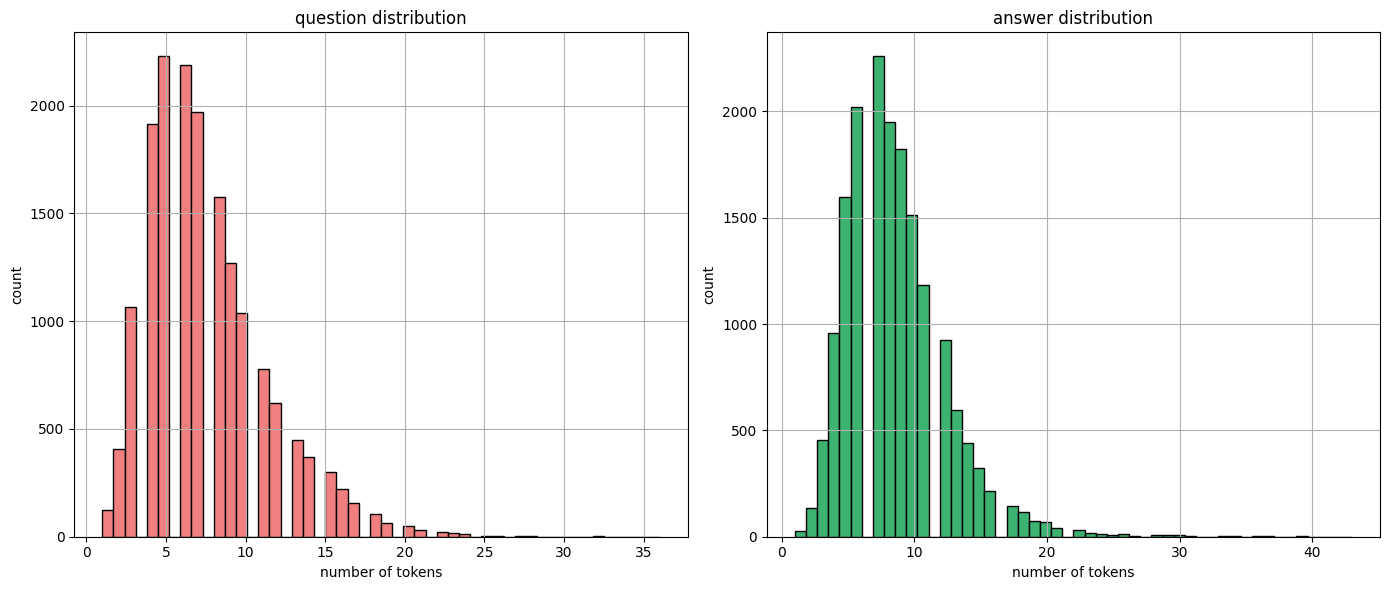

In [65]:
df["Q_"] = df["Q"].apply(preprocess)
df["A_"] = df["A"].apply(preprocess)
token_leng1 = df["Q_"].apply(lambda x: len(x))
token_leng2 = df["A_"].apply(lambda x: len(x))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(token_leng1, bins=50, color="lightcoral", edgecolor="black")
plt.title("question distribution")
plt.xlabel("number of tokens")
plt.ylabel("count")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(token_leng2, bins=50, color="mediumseagreen", edgecolor="black")
plt.title("answer distribution")
plt.xlabel("number of tokens")
plt.ylabel("count")
plt.grid(True)

plt.tight_layout()
plt.show()

In [66]:
def build_corpus(df):
    df.dropna(inplace=True)
    df["Q_"] = df["Q"].apply(preprocess)
    df["A_"] = df["A"].apply(preprocess)
    df.drop_duplicates(subset=["Q_"], inplace=True)
    df.drop_duplicates(subset=["A_"], inplace=True)
    df.reset_index(drop=True, inplace=True)

    que_corpus, ans_corpus = [], []
    for i in range(len(df)):
        if len(df["Q_"][i]) < 28 and len(df["A_"][i]) < 35:
            que_corpus.append(df["Q_"][i])
            ans_corpus.append(["<SOS>"] + df["A_"][i] + ["<EOS>"])
    return que_corpus, ans_corpus

In [67]:
que_corpus, ans_corpus = build_corpus(df)

In [68]:
def compute_vocab_coverage(corpus, topk_list=[1000, 2000, 5000, 8000, 10000, 20000]):
    tokenizer = Tokenizer(filters="", oov_token=None)
    tokenizer.fit_on_texts(corpus)

    word_counts = tokenizer.word_counts  # collections.OrderedDict
    sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    total_tokens = sum([count for _, count in sorted_counts])

    print(f"Ï¥ù ÌÜ†ÌÅ∞ Ïàò: {total_tokens}")
    print(f"Ï†ÑÏ≤¥ Îã®Ïñ¥ Ïàò (Í≥†Ïú†): {len(sorted_counts)}")

    cumulative = np.cumsum([count for _, count in sorted_counts])
    coverage_list = [
        cumulative[k - 1] / total_tokens * 100 if k <= len(cumulative) else 100.0
        for k in topk_list
    ]

    for k, cov in zip(topk_list, coverage_list):
        print(f"Vocab Size = {k:5d} ‚Üí Coverage: {cov:.2f}%")

    plt.figure(figsize=(8, 4))
    plt.plot(np.arange(1, len(cumulative) + 1), cumulative / total_tokens * 100)
    plt.xlabel("Vocab Size (Top-N Words)")
    plt.ylabel("Coverage (%)")
    plt.title("Vocab Size vs. Token Coverage")
    plt.grid(True)
    plt.axhline(95, color="r", linestyle="--", label="95% Cutoff")
    plt.legend()
    plt.tight_layout()
    plt.show()

Ï¥ù ÌÜ†ÌÅ∞ Ïàò: 57276
Ï†ÑÏ≤¥ Îã®Ïñ¥ Ïàò (Í≥†Ïú†): 4562
Vocab Size =  1000 ‚Üí Coverage: 89.87%
Vocab Size =  2000 ‚Üí Coverage: 94.96%
Vocab Size =  5000 ‚Üí Coverage: 100.00%
Vocab Size =  8000 ‚Üí Coverage: 100.00%
Vocab Size = 10000 ‚Üí Coverage: 100.00%
Vocab Size = 20000 ‚Üí Coverage: 100.00%


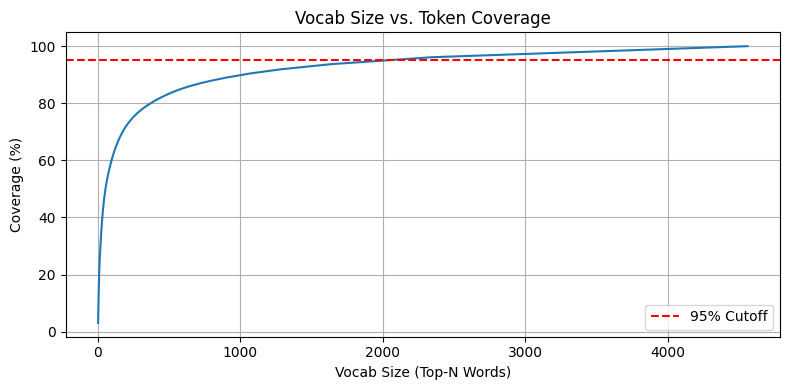

In [69]:
compute_vocab_coverage(que_corpus)

In [70]:
def tokenize(corpus1, corpus2, vocab_size=None, oov_token="<OOV>"):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, filters="")
    tokenizer.fit_on_texts(corpus1 + corpus2)

    tensor1 = tokenizer.texts_to_sequences(corpus1)
    tensor2 = tokenizer.texts_to_sequences(corpus2)

    tensor1 = tf.keras.preprocessing.sequence.pad_sequences(tensor1, padding="post")
    tensor2 = tf.keras.preprocessing.sequence.pad_sequences(tensor2, padding="post")

    return tensor1, tensor2, tokenizer

In [71]:
enc_corpus, dec_corpus, tokenizer = tokenize(que_corpus, ans_corpus)

In [72]:
enc_train = enc_corpus[:-DF_VALID_LEN]
dec_train = dec_corpus[:-DF_VALID_LEN]

enc_test = enc_corpus[-DF_VALID_LEN:]
dec_test = dec_corpus[-DF_VALID_LEN:]

BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = (
    train_dataset.shuffle(len(enc_train)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

valid_dataset = tf.data.Dataset.from_tensor_slices((enc_test, dec_test))
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [73]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2 * (i // 2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table


def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]


def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask


def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask


# Multi Head Attention Íµ¨ÌòÑ
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None:
            scaled_qk += mask * -1e9

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights


class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation="relu")
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)

        return out


class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, enc_attn


class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        # Q, K, V ÏàúÏÑúÏóê Ï£ºÏùòÌïòÏÑ∏Ïöî!
        out, dec_enc_attn = self.enc_dec_attn(
            Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask
        )
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn


class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [
            EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)
        ]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns


class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [
            DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)
        ]

    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](
                out, enc_out, dec_enc_mask, padding_mask
            )

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns


class Transformer(tf.keras.Model):
    def __init__(
        self,
        n_layers,
        d_model,
        n_heads,
        d_ff,
        src_vocab_size,
        tgt_vocab_size,
        pos_len,
        dropout=0.2,
        shared_fc=True,
        shared_emb=False,
    ):
        super(Transformer, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = tf.keras.layers.Embedding(
                src_vocab_size, d_model
            )
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc:
            out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = self.decoder(
            dec_in, enc_out, dec_enc_mask, dec_mask
        )

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [74]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()

        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step**-0.5
        arg2 = step * (self.warmup_steps**-1.5)

        return (self.d_model**-0.5) * tf.math.minimum(arg1, arg2)

In [75]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [76]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # DecoderÏùò input
    gold = tgt[
        :, 1:
    ]  # DecoderÏùò outputÍ≥º ÎπÑÍµêÌïòÍ∏∞ ÏúÑÌï¥ right shiftÎ•º ÌÜµÌï¥ ÏÉùÏÑ±Ìïú ÏµúÏ¢Ö ÌÉÄÍ≤ü

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(
            src, tgt_in, enc_mask, dec_enc_mask, dec_mask
        )
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [77]:
@tf.function
def eval_step(src, tgt, model):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    predictions, enc_attns, dec_attns, dec_enc_attns = model(
        src, tgt_in, enc_mask, dec_enc_mask, dec_mask
    )

    loss = loss_function(gold, predictions)

    return loss, enc_attns, dec_attns, dec_enc_attns

In [78]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.wait = 0
        self.stopped_epoch = 0
        self.stop_training = False

    def on_epoch_end(self, epoch, current):
        if self.best is None or current < self.best - self.min_delta:
            self.best = current
            self.wait = 0
            return True
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stop_training = True
                self.stopped_epoch = epoch
            return False

In [79]:
def plot_loss_graph(train_log, test_log):
    epochs = range(1, len(train_log) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_log, label="Train Loss")
    plt.plot(epochs, test_log, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train/Test Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [80]:
from nltk.translate.bleu_score import sentence_bleu

def compute_bleu_score(reference_texts, generated_texts):
    scores = []
    for ref, gen in zip(reference_texts, generated_texts):
        ref_tokens = ref.split()
        gen_tokens = gen.split()
        score = sentence_bleu([ref_tokens], gen_tokens, weights=(0.5, 0.5))
        scores.append(score)
    return sum(scores) / len(scores) if scores else 0

In [122]:
def ids_to_text(tokenizer, ids, pad_id=0):
    return ' '.join([tokenizer.index_word.get(i, '') for i in ids if i != 0 and i != pad_id])

def compute_bleu_from_validation(model, tokenizer, dataset, num_samples=None, sos_id=2, eos_id=3, pad_id=0):
    references = []
    predictions = []
    count = 0

    for src_batch, tgt_batch in dataset:
        for src, tgt in zip(src_batch.numpy(), tgt_batch.numpy()):
            if num_samples is not None and count >= num_samples:
                break

            src_text = ids_to_text(tokenizer, src, pad_id)
            tgt_text = ids_to_text(tokenizer, tgt[1:], pad_id)

            pred_text = greedy_decode(model, tokenizer, src_text, sos_id=sos_id, eos_id=eos_id)

            references.append(tgt_text)
            predictions.append(pred_text)

            count += 1

        if num_samples is not None and count >= num_samples:
            break

    return compute_bleu_score(references, predictions)


In [82]:
def greedy_decode(model, tokenizer, src_sentence, max_len=50, pad_id=0, sos_id=1, eos_id=2):
    # 1. ÏûÖÎ†• Î¨∏Ïû•ÏùÑ Ï†ïÏàò ÏãúÌÄÄÏä§Î°ú Î≥ÄÌôò
    src_ids = tokenizer.texts_to_sequences([src_sentence])[0]
    src_tensor = tf.constant([src_ids], dtype=tf.int32)

    # 2. encoder Ï∂úÎ†• ÏÉùÏÑ±
    enc_mask = generate_padding_mask(src_tensor)
    enc_input = model.embedding(model.enc_emb, src_tensor)
    enc_output, enc_attns = model.encoder(enc_input, enc_mask)

    # 3. ÎîîÏΩîÎçî ÏûÖÎ†• Ï¥àÍ∏∞Ìôî (<sos>Îßå Ìè¨Ìï®)
    output_ids = [sos_id]

    for _ in range(max_len):
        dec_input = tf.constant([output_ids], dtype=tf.int32)

        # ÎßàÏä§ÌÅ¨ ÏÉùÏÑ±
        dec_enc_mask = generate_padding_mask(src_tensor)
        dec_mask = tf.maximum(generate_padding_mask(dec_input), generate_lookahead_mask(len(output_ids)))

        # ÎîîÏΩîÎçî ÌÜµÍ≥º
        dec_emb = model.embedding(model.dec_emb, dec_input)
        dec_output, _, _ = model.decoder(dec_emb, enc_output, dec_enc_mask, dec_mask)

        # Ï∂úÎ†• Îã®Ïñ¥ ÏòàÏ∏° (ÎßàÏßÄÎßâ ÌÜ†ÌÅ∞ Í∏∞Ï§Ä)
        logits = model.fc(dec_output)  # shape: (1, seq_len, vocab_size)
        next_token = tf.argmax(logits[:, -1, :], axis=-1).numpy()[0]

        # Ï¢ÖÎ£å Ï°∞Í±¥
        if next_token == eos_id:
            break

        output_ids.append(next_token)

    # Ï†ïÏàò ÏãúÌÄÄÏä§Î•º Î¨∏Ïû•ÏúºÎ°ú Î≥ÄÌôò
    result = ' '.join([tokenizer.index_word.get(i, '<unk>') for i in output_ids[1:]])  # <sos> Ï†úÏô∏
    return result


In [83]:
def main(
    transformer,
    optimizer,
    name,
    EPOCHS=10,
    early_stopping=EarlyStopping(patience=3, min_delta=0.001),
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    save=True,
):
    train_log = []
    valid_log = []

    for epoch in range(EPOCHS):
        total_loss = 0
        dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
        tqdm_bar = tqdm(total=dataset_count)

        for batch, (src, tgt) in enumerate(train_dataset):
            loss, _, _, _ = train_step(src, tgt, transformer, optimizer)
            total_loss += loss
            tqdm_bar.set_description(f"Epoch {epoch + 1}")
            tqdm_bar.set_postfix(loss=total_loss.numpy() / (batch + 1))
            tqdm_bar.update(1)

        tqdm_bar.close()
        train_epoch_loss = total_loss.numpy() / dataset_count
        train_log.append(train_epoch_loss)

        val_loss_total = 0
        val_batches = tf.data.experimental.cardinality(valid_dataset).numpy()

        for batch, (src, tgt) in enumerate(valid_dataset):
            loss, _, _, _ = eval_step(src, tgt, transformer)
            val_loss_total += loss

        val_epoch_loss = val_loss_total.numpy() / val_batches
        valid_log.append(val_epoch_loss)

        # BLEU Í≥ÑÏÇ∞
        bleu_score = compute_bleu_from_validation(transformer, tokenizer, valid_dataset, num_samples=10)

        print(f"[Epoch {epoch + 1}] BLEU: {bleu_score:.4f}")

        is_best = early_stopping.on_epoch_end(epoch, val_epoch_loss)
        if save and is_best:
            transformer.save_weights(name + "best_model.weights.h5")
            print(f"Best model saved at epoch {epoch+1}")

        if early_stopping.stop_training:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    plot_loss_graph(train_log, valid_log)

    if save:
        transformer.load_weights(name + "best_model.weights.h5")

    return transformer, train_log, valid_log

---

In [84]:
import tensorflow.keras.backend as K

K.clear_session()

In [85]:
transformer1 = Transformer(
    n_layers=1,
    d_model=512,
    n_heads=8,
    d_ff=1024,
    src_vocab_size=len(tokenizer.word_index) + 1,
    tgt_vocab_size=len(tokenizer.word_index) + 1,
    pos_len=80,
    dropout=0.2,
    shared_fc=True,
    shared_emb=True,
)

d_model = 512

In [86]:
learning_rate = LearningRateScheduler(d_model, warmup_steps=1000)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

early_stopping = EarlyStopping(patience=4, min_delta=0.001)

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 1] BLEU: 0.0000
Best model saved at epoch 1


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 2] BLEU: 0.0161
Best model saved at epoch 2


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 3] BLEU: 0.0054
Best model saved at epoch 3


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 4] BLEU: 0.0474


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 5] BLEU: 0.0481


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 6] BLEU: 0.0240


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 7] BLEU: 0.0126
Early stopping triggered at epoch 7


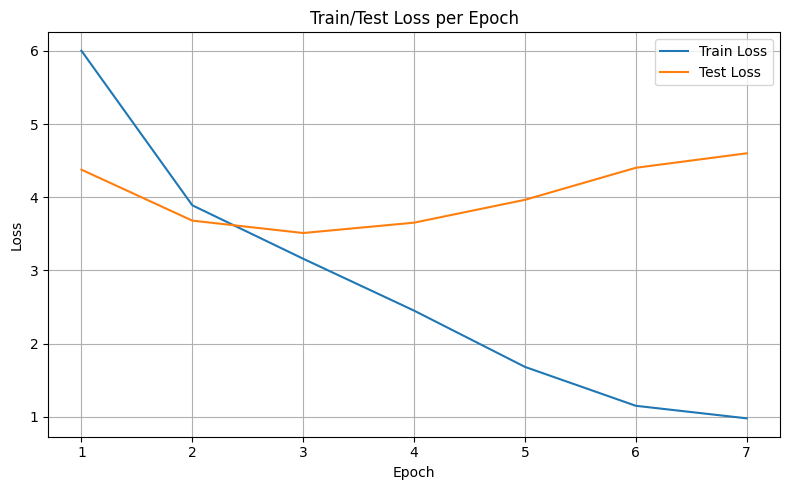

In [87]:
transformer1, train_log, valid_log = main(
    transformer1,
    optimizer,
    "transformer1_",
    EPOCHS=10,
    early_stopping=early_stopping,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
)

#2.hyperparam

In [88]:
tf.config.run_functions_eagerly(True)

In [108]:
def tuner(transformer_args, name, warmup_steps=1000, epoch=10):
    transformer = Transformer(**transformer_args)
    d_model = transformer_args["d_model"]

    learning_rate = LearningRateScheduler(d_model, warmup_steps=1000)
    optimizer = tf.keras.optimizers.Adam(
        learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
    )
    early_stopping = EarlyStopping(patience=3, min_delta=0.001)

    transformer, train_log, valid_log = main(
        transformer,
        optimizer,
        name,
        EPOCHS=epoch,
        early_stopping=early_stopping,
        train_dataset=train_dataset,
        valid_dataset=valid_dataset,
        save=True,
    )
    return early_stopping.best

In [109]:
search_space = {
    "n_layers": [1, 2],
    "d_model": [128, 368],
    "n_heads": [8],
    "d_ff": [1024],
    "dropout": [0.2],
}
warmup = 500

In [110]:
from itertools import product
import tensorflow.keras.backend as K

# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï°∞Ìï© ÏÉùÏÑ±
keys, values = zip(*search_space.items())
arg_combinations = [dict(zip(keys, v)) for v in product(*values)]

In [111]:
print(f"ÏÉùÏÑ±Îêú ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï°∞Ìï© Ïàò: {len(arg_combinations)}")
for combo in arg_combinations:
    print(combo)

ÏÉùÏÑ±Îêú ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï°∞Ìï© Ïàò: 4
{'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
{'n_layers': 1, 'd_model': 368, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
{'n_layers': 2, 'd_model': 128, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
{'n_layers': 2, 'd_model': 368, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}



--- Trial 1/4: {'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2} ---
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 1] BLEU: 0.0000
Best model saved at epoch 1


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 2] BLEU: 0.0352
Best model saved at epoch 2


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 3] BLEU: 0.0122
Best model saved at epoch 3


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 4] BLEU: 0.0189
Best model saved at epoch 4


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 5] BLEU: 0.0483
Best model saved at epoch 5


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 6] BLEU: 0.0000


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 7] BLEU: 0.0193


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 8] BLEU: 0.0357
Early stopping triggered at epoch 8


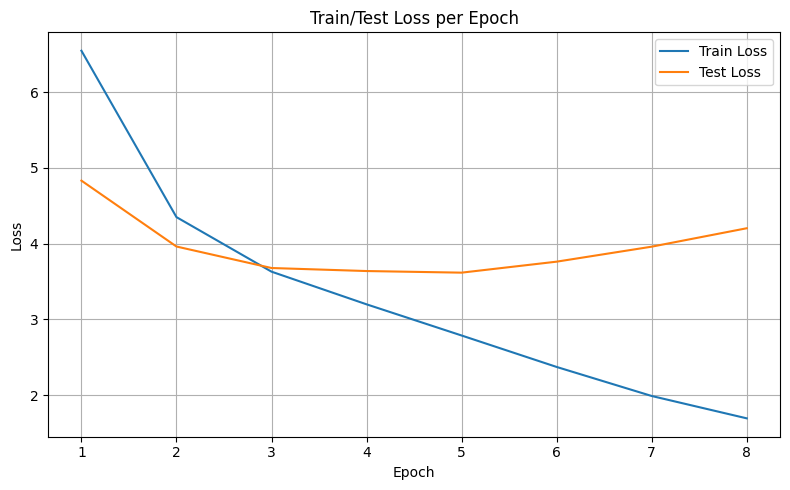


--- Trial 2/4: {'n_layers': 1, 'd_model': 368, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2} ---
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 1] BLEU: 0.0000
Best model saved at epoch 1


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 2] BLEU: 0.0000
Best model saved at epoch 2


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 3] BLEU: 0.0122
Best model saved at epoch 3


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 4] BLEU: 0.0066


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 5] BLEU: 0.0614


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 6] BLEU: 0.0000
Early stopping triggered at epoch 6


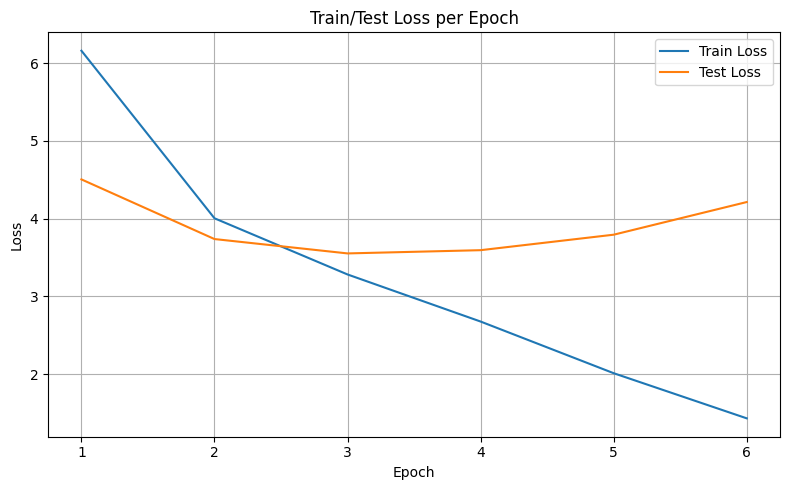


--- Trial 3/4: {'n_layers': 2, 'd_model': 128, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2} ---
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 1] BLEU: 0.0000
Best model saved at epoch 1


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 2] BLEU: 0.0041
Best model saved at epoch 2


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 3] BLEU: 0.0000
Best model saved at epoch 3


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 4] BLEU: 0.0512
Best model saved at epoch 4


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 5] BLEU: 0.0000


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 6] BLEU: 0.0165


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 7] BLEU: 0.0168
Early stopping triggered at epoch 7


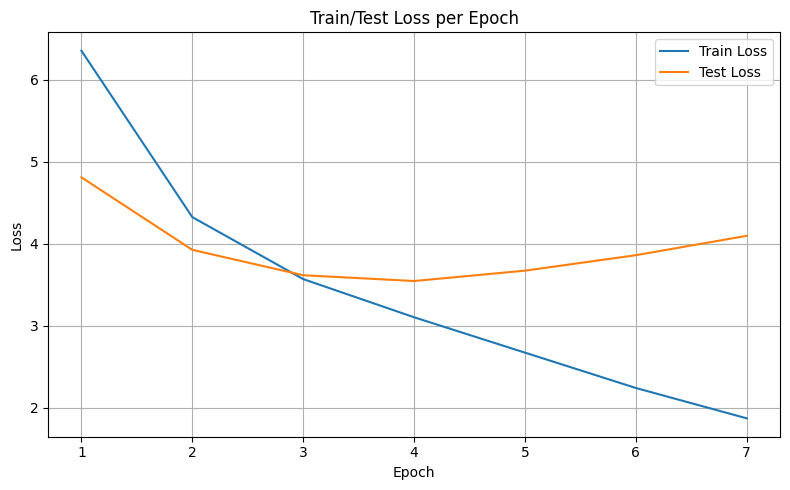


--- Trial 4/4: {'n_layers': 2, 'd_model': 368, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2} ---
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 1] BLEU: 0.0145
Best model saved at epoch 1


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 2] BLEU: 0.0000
Best model saved at epoch 2


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 3] BLEU: 0.0425
Best model saved at epoch 3


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 4] BLEU: 0.0000


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 5] BLEU: 0.0170


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 6] BLEU: 0.0000
Early stopping triggered at epoch 6


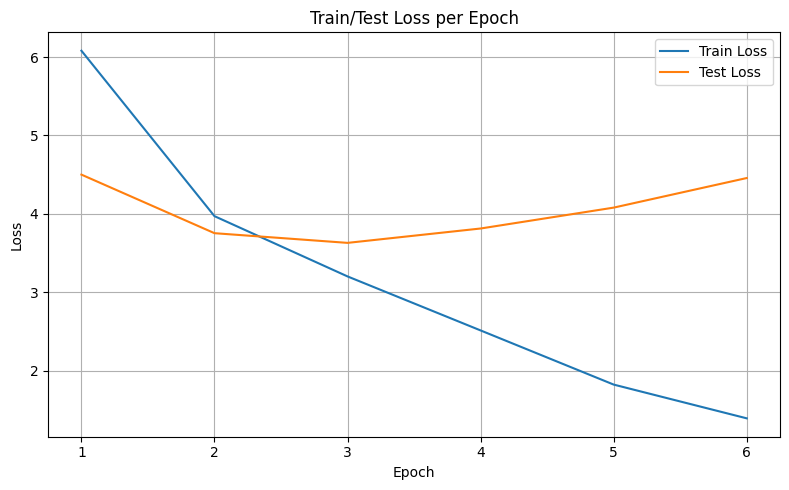


--- Hyperparameter Tuning Complete ---
Results:
[(1, 128, 8, 1024, 0.2, 500, (<Transformer name=transformer_1, built=True>, np.float64(3.6176983759953427))), (1, 368, 8, 1024, 0.2, 500, (<Transformer name=transformer, built=True>, np.float64(3.552350264329177))), (2, 128, 8, 1024, 0.2, 500, (<Transformer name=transformer, built=True>, np.float64(3.5465768667367787))), (2, 368, 8, 1024, 0.2, 500, (<Transformer name=transformer, built=True>, np.float64(3.6310914846567006)))]


In [113]:
result = []
hp_order = ["n_layers", "d_model", "n_heads", "d_ff", "dropout"]

# Í∞Å ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï°∞Ìï©Ïóê ÎåÄÌï¥ ÌïôÏäµ Ïã§Ìñâ
for i, hp_args in enumerate(arg_combinations):
    print(f"\n--- Trial {i+1}/{len(arg_combinations)}: {hp_args} ---")

    # Î™®Îç∏ ÏÉùÏÑ±Ïóê ÌïÑÏöîÌïú Ï†ÑÏ≤¥ Ïù∏Ïûê Íµ¨ÏÑ±
    full_args = {
        "src_vocab_size": len(tokenizer.word_index) + 1, # tokenizerÎäî Ïù¥Ï†ÑÏóê Ï†ïÏùòÎêú Í∞ùÏ≤¥Î•º ÏÇ¨Ïö©
        "tgt_vocab_size": len(tokenizer.word_index) + 1, # tokenizerÎäî Ïù¥Ï†ÑÏóê Ï†ïÏùòÎêú Í∞ùÏ≤¥Î•º ÏÇ¨Ïö©
        "pos_len": 80, # Îç∞Ïù¥ÌÑ∞ÏÖã ÏµúÎåÄ Í∏∏Ïù¥ Îì±ÏùÑ Í≥†Î†§ÌïòÏó¨ ÏÑ§Ï†ï
        "shared_fc": True,
        "shared_emb": True,
        **hp_args, # ÌòÑÏû¨ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï°∞Ìï© Ï∂îÍ∞Ä
    }

    print(f"Warmup Steps: {warmup}")

    # tuner Ìï®ÏàòÎ•º Ìò∏Ï∂úÌïòÏó¨ Î™®Îç∏ ÌïôÏäµ ÏßÑÌñâ
    # tuner Ìï®Ïàò ÎÇ¥ÏóêÏÑú ÌïôÏäµ ÏßÑÌñâ ÏÉÅÌô© (Loss, PPL, BLEU)Ïù¥ Ï∂úÎ†•Îê©ÎãàÎã§.
    best_val_loss = tuner(
        full_args,
        f"transformer_trial_{i+1}_", # Í∞Å trialÎ≥ÑÎ°ú Îã§Î•∏ Ïù¥Î¶Ñ Î∂ÄÏó¨
        warmup_steps=warmup,
        epoch=20 # ÌïôÏäµ epoch ÏàòÎ•º ÏÑ§Ï†ï (Early StoppingÏóê ÏùòÌï¥ Ï°∞Í∏∞ Ï¢ÖÎ£åÎê† Ïàò ÏûàÏäµÎãàÎã§)
    )

    # Í≤∞Í≥ºÎ•º Ï†ÄÏû• (ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï°∞Ìï©Í≥º Best Validation Loss)
    hp_tuple = tuple(hp_args[k] for k in hp_order) + (warmup, best_val_loss)
    result.append(hp_tuple)

    # Îã§Ïùå ÌïôÏäµÏùÑ ÏúÑÌï¥ Keras ÏÑ∏ÏÖò Ï¥àÍ∏∞Ìôî
    K.clear_session()

print("\n--- Hyperparameter Tuning Complete ---")
print("Results:")
print(result)

In [114]:
result.sort(key=lambda x: x[6])
print("Best config:", result[0])
print("Second best config:", result[1])
print("Third best config:", result[2])

Best config: (2, 128, 8, 1024, 0.2, 500, (<Transformer name=transformer, built=True>, np.float64(3.5465768667367787)))
Second best config: (1, 368, 8, 1024, 0.2, 500, (<Transformer name=transformer, built=True>, np.float64(3.552350264329177)))
Third best config: (1, 128, 8, 1024, 0.2, 500, (<Transformer name=transformer_1, built=True>, np.float64(3.6176983759953427)))


In [115]:
result

[(2,
  128,
  8,
  1024,
  0.2,
  500,
  (<Transformer name=transformer, built=True>,
   np.float64(3.5465768667367787))),
 (1,
  368,
  8,
  1024,
  0.2,
  500,
  (<Transformer name=transformer, built=True>, np.float64(3.552350264329177))),
 (1,
  128,
  8,
  1024,
  0.2,
  500,
  (<Transformer name=transformer_1, built=True>,
   np.float64(3.6176983759953427))),
 (2,
  368,
  8,
  1024,
  0.2,
  500,
  (<Transformer name=transformer, built=True>,
   np.float64(3.6310914846567006)))]

# 3. ÌèâÍ∞Ä ÏßÄÌëú

In [116]:
import torch
import math
from transformers import AutoTokenizer, AutoModelForCausalLM

def calculate_chatbot_perplexity(model_name: str, qa_pairs: list, device: str = 'cuda' if torch.cuda.is_available() else 'cpu') -> float:
    """
    Ï±óÎ¥áÏùò ÎãµÎ≥Ä ÏÉùÏÑ± Îä•Î†•ÏùÑ ÌèâÍ∞ÄÌïòÍ∏∞ ÏúÑÌïú perplexity Í≥ÑÏÇ∞

    Args:
        model_name: HuggingFace Î™®Îç∏ Ïù¥Î¶Ñ
        qa_pairs: [(ÏßàÎ¨∏, ÎãµÎ≥Ä), (ÏßàÎ¨∏, ÎãµÎ≥Ä), ...] ÌòïÌÉúÏùò Î¶¨Ïä§Ìä∏
        device: 'cuda' or 'cpu'

    Returns:
        ÎãµÎ≥Ä ÏÉùÏÑ±Ïóê ÎåÄÌïú ÌèâÍ∑† perplexity
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
    model.eval()

    # padding token ÏÑ§Ï†ï
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    total_loss = 0.0
    total_length = 0

    for question, answer in qa_pairs:
        # ÏßàÎ¨∏Í≥º ÎãµÎ≥ÄÏùÑ ÌïòÎÇòÏùò ÎåÄÌôî ÌòïÌÉúÎ°ú Íµ¨ÏÑ±
        conversation = f"ÏßàÎ¨∏: {question}\nÎãµÎ≥Ä: {answer}"

        # ÌÜ†ÌÅ¨ÎÇòÏù¥Ïßï
        inputs = tokenizer(conversation, return_tensors='pt', padding=True)
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        # ÏßàÎ¨∏ Î∂ÄÎ∂ÑÏùò ÌÜ†ÌÅ∞ Í∏∏Ïù¥ Í≥ÑÏÇ∞ (ÎãµÎ≥Ä Î∂ÄÎ∂ÑÎßå loss Í≥ÑÏÇ∞ÌïòÍ∏∞ ÏúÑÌï¥)
        question_part = f"ÏßàÎ¨∏: {question}\nÎãµÎ≥Ä: "
        question_inputs = tokenizer(question_part, return_tensors='pt')
        question_length = question_inputs['input_ids'].size(1)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)

            # Ï†ÑÏ≤¥ lossÏóêÏÑú ÏßàÎ¨∏ Î∂ÄÎ∂Ñ Ï†úÏô∏ÌïòÍ≥† ÎãµÎ≥Ä Î∂ÄÎ∂ÑÎßå Í≥ÑÏÇ∞
            shift_logits = outputs.logits[..., :-1, :].contiguous()
            shift_labels = input_ids[..., 1:].contiguous()

            # ÎãµÎ≥Ä Î∂ÄÎ∂ÑÎßå ÎßàÏä§ÌÇπ
            answer_mask = torch.zeros_like(shift_labels, dtype=torch.bool)
            answer_mask[:, question_length-1:] = True  # ÎãµÎ≥Ä Î∂ÄÎ∂ÑÎßå True

            # Cross entropy loss Í≥ÑÏÇ∞ (ÎãµÎ≥Ä Î∂ÄÎ∂ÑÎßå)
            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
            losses = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            losses = losses.view(shift_labels.shape)

            # ÎãµÎ≥Ä Î∂ÄÎ∂ÑÏùò lossÎßå Í≥ÑÏÇ∞
            masked_losses = losses * answer_mask.float()
            answer_loss = masked_losses.sum() / answer_mask.sum()

        answer_length = answer_mask.sum().item()
        if answer_length > 0:
            total_loss += answer_loss.item() * answer_length
            total_length += answer_length

    if total_length == 0:
        return float('inf')

    avg_loss = total_loss / total_length
    return math.exp(avg_loss)


# 4. ÌÖåÏä§Ìä∏

In [118]:
!ls /content/*.h5

/content/transformer1_best_model.weights.h5
/content/transformer_trial_1_best_model.weights.h5
/content/transformer_trial_2_best_model.weights.h5
/content/transformer_trial_3_best_model.weights.h5
/content/transformer_trial_4_best_model.weights.h5


In [121]:
test_sentence = ["ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥.", "Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§.", "Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥.", "ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº."]
response = []
ppl_score = []
for i, hp_args in enumerate(arg_combinations):
    model_weights_path = f"/content/transformer_trial_{i+1}_best_model.weights.h5"
    full_args = {
        "src_vocab_size": len(tokenizer.word_index) + 1, # tokenizerÎäî Ïù¥Ï†ÑÏóê Ï†ïÏùòÎêú Í∞ùÏ≤¥Î•º ÏÇ¨Ïö©
        "tgt_vocab_size": len(tokenizer.word_index) + 1, # tokenizerÎäî Ïù¥Ï†ÑÏóê Ï†ïÏùòÎêú Í∞ùÏ≤¥Î•º ÏÇ¨Ïö©
        "pos_len": 80, # Îç∞Ïù¥ÌÑ∞ÏÖã ÏµúÎåÄ Í∏∏Ïù¥ Îì±ÏùÑ Í≥†Î†§ÌïòÏó¨ ÏÑ§Ï†ï
        "shared_fc": True,
        "shared_emb": True,
        **hp_args, # ÌòÑÏû¨ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï°∞Ìï© Ï∂îÍ∞Ä
    }
    model = Transformer(**full_args)

    # ÎçîÎØ∏ ÏûÖÎ†•ÏúºÎ°ú Î™®Îç∏ Ìò∏Ï∂úÌï¥ÏÑú ÎπåÎìú
    dummy_enc = tf.constant([[1, 2, 3]])  # shape = (1, seq_len)
    dummy_dec = tf.constant([[1, 2, 3]])

    enc_mask, dec_enc_mask, dec_mask = generate_masks(dummy_enc, dummy_dec)

    _ = model(dummy_enc, dummy_dec, enc_mask, dec_enc_mask, dec_mask)  # Ìò∏Ï∂úÎ°ú buildÎê®

    model.load_weights(model_weights_path)
    print(hp_args)
    for idx, sentence in enumerate(test_sentence):
        response.append(greedy_decode(model, tokenizer, sentence, sos_id=2, eos_id=3))
        ppl_score.append(calculate_chatbot_perplexity(model_name="gpt2", qa_pairs=[(sentence, response[idx])]))
        print("ÏßàÎ¨∏:", sentence)
        print("ü§ñ Ï±óÎ¥á ÏùëÎãµ:", response[idx], " ppl Ï†êÏàò:", ppl_score[idx])
    print("---------------------------------------------")

{'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


ÏßàÎ¨∏: ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥.
ü§ñ Ï±óÎ¥á ÏùëÎãµ: Í∑∏Îü∞ ÏÇ¨Îûå ÏùÄ Ìï≠ÏÉÅ Ïò§ Ï£† .  ppl Ï†êÏàò: 13.541310866099353
ÏßàÎ¨∏: Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§.
ü§ñ Ï±óÎ¥á ÏùëÎãµ: Ïò§Îäò ÏùÄ Ìï≠ÏÉÅ ÏùºÏñ¥ÎÇò ÏÑ∏Ïöî .  ppl Ï†êÏàò: 6.346775459320969
ÏßàÎ¨∏: Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥.
ü§ñ Ï±óÎ¥á ÏùëÎãµ: Ïª§Ìîº Ìñ• Ï¢ã Ï£† .  ppl Ï†êÏàò: 27.895495475805564
ÏßàÎ¨∏: ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº.
ü§ñ Ï±óÎ¥á ÏùëÎãµ: Í∑∏Îü∞ ÏÇ¨Îûå ÏùÄ Ìï≠ÏÉÅ Ïò§ Ï£† .  ppl Ï†êÏàò: 13.083669893954825
---------------------------------------------
{'n_layers': 1, 'd_model': 368, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
ÏßàÎ¨∏: ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥.
ü§ñ Ï±óÎ¥á ÏùëÎãµ: Í∑∏Îü∞ ÏÇ¨Îûå ÏùÄ Ìï≠ÏÉÅ Ïò§ Ï£† .  ppl Ï†êÏàò: 13.541310866099353
ÏßàÎ¨∏: Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§.
ü§ñ Ï±óÎ¥á ÏùëÎãµ: Ïò§Îäò ÏùÄ Ìï≠ÏÉÅ ÏùºÏñ¥ÎÇò ÏÑ∏Ïöî .  ppl Ï†êÏàò: 6.346775459320969
ÏßàÎ¨∏: Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥.
ü§ñ Ï±óÎ¥á Ïùë

### Translations
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. /Í∑∏Îü∞ ÏÇ¨Îûå ÏùÄ Ìï≠ÏÉÅ Ïò§ Ï£† .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. / Ïò§Îäò ÏùÄ Ìï≠ÏÉÅ ÏùºÏñ¥ÎÇò ÏÑ∏Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. / Ïª§Ìîº Ìñ• Ï¢ã Ï£† .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. / Í∑∏Îü∞ ÏÇ¨Îûå ÏùÄ Ìï≠ÏÉÅ Ïò§ Ï£† .

In [124]:
print("üìä ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï°∞Ìï©Î≥Ñ BLEU ÌèâÍ∞Ä ÏãúÏûë")

for i, hp_args in enumerate(arg_combinations):
    print(f"\nüîπ Trial {i+1}/{len(arg_combinations)}")
    print(f"‚Üí ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞: {hp_args}")

    model_weights_path = f"/content/transformer_trial_{i+1}_best_model.weights.h5"

    full_args = {
        "src_vocab_size": len(tokenizer.word_index) + 1,
        "tgt_vocab_size": len(tokenizer.word_index) + 1,
        "pos_len": 80,
        "shared_fc": True,
        "shared_emb": True,
        **hp_args,
    }

    model = Transformer(**full_args)

    # Î™®Îç∏ ÎπåÎìú (ÎçîÎØ∏ ÏûÖÎ†•)
    dummy_enc = tf.constant([[1, 2, 3]])
    dummy_dec = tf.constant([[1, 2, 3]])
    enc_mask, dec_enc_mask, dec_mask = generate_masks(dummy_enc, dummy_dec)
    _ = model(dummy_enc, dummy_dec, enc_mask, dec_enc_mask, dec_mask)

    try:
        model.load_weights(model_weights_path)
        print("‚úÖ Î™®Îç∏ Í∞ÄÏ§ëÏπò Î°úÎìú ÏôÑÎ£å")

        print("üß† BLEU ÌèâÍ∞Ä Ï§ë...")
        bleu_score = compute_bleu_from_validation(model, tokenizer, valid_dataset)
        print(f"üéØ BLEU Ï†êÏàò: {bleu_score:.4f}")

    except Exception as e:
        print(f"‚ùå Î™®Îç∏ Î°úÎìú Ïã§Ìå®: {e}")


üìä ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï°∞Ìï©Î≥Ñ BLEU ÌèâÍ∞Ä ÏãúÏûë

üîπ Trial 1/4
‚Üí ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞: {'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
‚úÖ Î™®Îç∏ Í∞ÄÏ§ëÏπò Î°úÎìú ÏôÑÎ£å
üß† BLEU ÌèâÍ∞Ä Ï§ë...


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


üéØ BLEU Ï†êÏàò: 0.0355

üîπ Trial 2/4
‚Üí ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞: {'n_layers': 1, 'd_model': 368, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
‚úÖ Î™®Îç∏ Í∞ÄÏ§ëÏπò Î°úÎìú ÏôÑÎ£å
üß† BLEU ÌèâÍ∞Ä Ï§ë...
üéØ BLEU Ï†êÏàò: 0.0374

üîπ Trial 3/4
‚Üí ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞: {'n_layers': 2, 'd_model': 128, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
‚úÖ Î™®Îç∏ Í∞ÄÏ§ëÏπò Î°úÎìú ÏôÑÎ£å
üß† BLEU ÌèâÍ∞Ä Ï§ë...
üéØ BLEU Ï†êÏàò: 0.0355

üîπ Trial 4/4
‚Üí ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞: {'n_layers': 2, 'd_model': 368, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
‚úÖ Î™®Îç∏ Í∞ÄÏ§ëÏπò Î°úÎìú ÏôÑÎ£å
üß† BLEU ÌèâÍ∞Ä Ï§ë...
üéØ BLEU Ï†êÏàò: 0.0364


# ÌöåÍ≥†
- Back translationÏúºÎ°ú Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ïÏùÑ ÌïòÎäî Í≥ºÏ†ïÏù¥ ÎÑàÎ¨¥ Ïò§Îûò Í±∏Î†∏Îã§.
    - Ï≤òÏùåÏóêÎäî gpt apiÎ•º ÌôúÏö©ÌñàÎäîÎç∞, ÏãúÍ∞ÑÏù¥ ÎÑàÎ¨¥ Ïò§Îûò Í±∏Î¶¨Í≥† ÌÜ†ÌÅ∞ Í∞ÄÍ≤©Ïù¥ ÎÑàÎ¨¥ ÎßéÏù¥ ÎÇòÍ∞Ä Ìè¨Í∏∞
    - ÌóàÍπÖÌéòÏù¥Ïä§Ïùò pretrained modelÏùÑ ÏÇ¨Ïö©ÌïòÎ†§Í≥† ÌñàÎäîÎç∞ ÎßéÏùÄ Î™®Îç∏Ïù¥ Í∏∞ÎåÄ Ïù¥ÌïòÏùò ÏÑ±Îä•
    - Í∏∞ÎåÄÎ•º Ï∂©Ï°±ÌïòÎäî Î™®Îç∏ÏùÄ ÎÑàÎ¨¥ ÎßéÏùÄ ÌååÎùºÎØ∏ÌÑ∞ Í∞ØÏàòÎ°ú ÏãúÍ∞ÑÏù¥ ÎÑàÎ¨¥ Ïò§Îûò Í±∏Î¶º
    - ÏÜçÎèÑÏôÄ ÏÑ±Îä• Î™®ÎëêÎ•º Ïñ¥ÎäêÏ†ïÎèÑ Ï∂©Ï°±ÌïòÎäî Î™®Îç∏ÏùÑ Ï∞æÎäî Îç∞ Ïò§Îûú ÏãúÍ∞ÑÏùÑ Îì§ÏûÑ
- Í∞ôÏùÄ Ï¶ùÍ∞ï Í∏∞Î≤ïÏóê ÎåÄÌï¥ ÌïòÏù¥Ìçº ÌååÎùºÎØ∏ÌÑ∞Î•º Î≥ÄÍ≤ΩÌï¥ Í∞ÄÎ©∞ ÏÑ±Îä•ÏùÑ ÎπÑÍµêÌïòÎ†§ ÌñàÎäîÎç∞ back translationÏùò Í≤ΩÏö∞ ÌïòÏù¥Ìçº ÌååÎùºÎØ∏ÌÑ∞Í∞Ä Î≥ÄÌï¥ÎèÑ ÏòàÎ¨∏Ïóê ÎåÄÌï¥ Í∞ôÏùÄ ÎåÄÎãµÏùÑ ÎÇ¥ÎÜìÎäî Í≤ÉÏù¥ ÏïÑÏâ¨Ïõ†Îã§.
    - NotionÏùò M1ÌåÄ Í≤∞Í≥ºÎ•º Î≥¥Î©¥ Îã§Î•∏ Ï¶ùÍ∞ï Í∏∞Î≤ïÏùò Í≤ΩÏö∞ ÌïòÏù¥Ìçº ÌååÎùºÎØ∏ÌÑ∞Í∞Ä Î∞îÎÄåÎ©¥ Í≤∞Í≥ºÎèÑ ÌÅ¨Í≤å Î∞îÎÄåÎäî Í≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÎã§.
    - back translation Ï¶ùÍ∞ï Í∏∞Î≤ïÏùò Îç∞Ïù¥ÌÑ∞ ÏñëÏù¥ Í∞ÄÏû• Ï†ÅÏñ¥ Í≥ºÏ†ÅÌï©Ïù¥ Îπ†Î•¥Í≤å ÏùºÏñ¥ÎÇ¨Îã§Í≥† ÌåêÎã®ÌïúÎã§.
- Ï¶ùÍ∞ï Í∏∞Î≤ï Ï§ë koEDAÎ•º ÏÇ¨Ïö©Ìïú Í≤ΩÏö∞ Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞Ïóê ÎπÑÌï¥ Ï¶ùÍ∞ïÎêú Îç∞Ïù¥ÌÑ∞Ïóê ÎßéÏùÄ Î≥ÄÌòïÏù¥ ÏûàÍ≥†, Ï¶ùÍ∞ï Îç∞Ïù¥ÌÑ∞ ÏûêÏ≤¥ÎèÑ Í∞ÄÏû• ÎßéÏïÑ ÏõêÎ≥∏ ÎåÄÎãµÍ≥º ÌÅ¨Í≤å Îã§Î•∏ ÏòàÎ¨∏ÏùÑ Ï∂úÎ†•ÌñàÎã§.
- lexical Ï¶ùÍ∞ïÏùò Í≤ΩÏö∞ Îã§ÏñëÌïú ÎåÄÎãµÏù¥ ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ÏôÄ ÎπÑÏä∑ÌïòÍ≤å Ï∂úÎ†•ÎêòÏóàÏúºÎÇò, Ï†ÑÏ≤¥Ï†ÅÏúºÎ°ú ÏßàÎ¨∏Ïóê ÎåÄÌïú ÎåÄÎãµÏúºÎ°ú ÏïÑÏ£º ÏïåÎßûÏùÄ ÎåÄÎãµÏùÄ Îî±Ìûà Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏïòÎã§.
- ÌïòÎ£®ÎßåÏóê ÌåÄÏõêÎì§Í≥º Î≤†Ïù¥Ïä§ÎùºÏù∏ ÏΩîÎìúÎ•º Í∏∞Î∞òÏúºÎ°ú Ï¶ùÍ∞ï Îç∞Ïù¥ÌÑ∞Î•º Ï∂îÍ∞ÄÌïòÏó¨ Í∞ôÏùÄ Ïã§ÌóòÏùÑ ÏßÑÌñâÌñàÏßÄÎßå, ÏàòÏóÖÏù¥ ÎÅùÎÇú ÌõÑ ÏΩîÎìúÎ•º ÏùºÎ∂Ä ÏÜêÎ≥¥Îäî Í≥ºÏ†ïÏóêÏÑú ÌåÄÏõêÎì§Í≥º ÏΩîÎìúÍ∞Ä Îã¨ÎùºÏßÄÍ≤å ÎêòÎ©∞ Î≥ÄÏù∏ ÌÜµÏ†úÍ∞Ä ÏôÑÎ≤ΩÌïòÏßÄ ÏïäÏùÑ Ïàò ÏûàÏùÑ Í≤ÉÏù¥Îùº ÏÉùÍ∞ÅÌïúÎã§.
- ÏãúÍ∞ÑÏù¥ ÌïòÎ£® Ï†ïÎèÑÎßå Îçî ÏûàÏóàÏúºÎ©¥ Ïã§Ìóò Í≤∞Í≥ºÏóê ÎåÄÌï¥ Ïñ¥Îñ§ ÏΩîÎìúÎ•º ÏàòÏ†ïÌïòÏòÄÎäîÏßÄ Ïù¥ÏïºÍ∏∞ÌïòÍ≥† ÏÑúÎ°ú Îã§Î•∏ Î∂ÄÎ∂ÑÏùÑ ÎßûÏ∂∞ÏÑú Îã§Ïãú Ïã§ÌóòÏùÑ ÏßÑÌñâÌïòÎ©¥ Îçî Ïù¥Ìï¥Ìï† ÎßåÌïú Ïã§Ìóò Í≤∞Í≥ºÍ∞Ä ÎÇòÏò¨ Í≤ÉÏù¥Îùº ÏÉùÍ∞ÅÌïúÎã§.